# Involutional neural networks

**Author:** [Aritra Roy Gosthipaty](https://twitter.com/ariG23498)<br>
**Date created:** 2021/07/25<br>
**Last modified:** 2021/07/25<br>
**Description:** Deep dive into location-specific and channel-agnostic "involution" kernels.

## Introduction

Convolution has been the basis of most modern neural
networks for computer vision. A convolution kernel is
spatial-agnostic and channel-specific. Because of this, it isn't able
to adapt to different visual patterns with respect to
different spatial locations. Along with location-related problems, the
receptive field of convolution creates challenges with regard to capturing
long-range spatial interactions.

To address the above issues, Li et. al. rethink the properties
of convolution in
[Involution: Inverting the Inherence of Convolution for VisualRecognition](https://arxiv.org/abs/2103.06255).
The authors propose the "involution kernel", that is location-specific and
channel-agnostic. Due to the location-specific nature of the operation,
the authors say that self-attention falls under the design paradigm of
involution.

This example describes the involution kernel, compares two image
classification models, one with convolution and the other with
involution, and also tries drawing a parallel with the self-attention
layer.

## Setup

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
import matplotlib.pyplot as plt

# Set seed for reproducibility.
tf.random.set_seed(42)

## Convolution

Convolution remains the mainstay of deep neural networks for computer vision.
To understand Involution, it is necessary to talk about the
convolution operation.

![Imgur](https://i.imgur.com/MSKLsm5.png)

Consider an input tensor **X** with dimensions **H**, **W** and
**C_in**. We take a collection of **C_out** convolution kernels each of
shape **K**, **K**, **C_in**. With the multiply-add operation between
the input tensor and the kernels we obtain an output tensor **Y** with
dimensions **H**, **W**, **C_out**.

In the diagram above `C_out=3`. This makes the output tensor of shape H,
W and 3. One can notice that the convoltuion kernel does not depend on
the spatial position of the input tensor which makes it
**location-agnostic**. On the other hand, each channel in the output
tensor is based on a specific convolution filter which makes is
**channel-specific**.

## Involution

The idea is to have an operation that is both **location-specific**
and **channel-agnostic**. Trying to implement these specific properties poses
a challenge. With a fixed number of involution kernels (for each
spatial position) we will **not** be able to process variable-resolution
input tensors.

To solve this problem, the authors have considered *generating* each
kernel conditioned on specific spatial positions. With this method, we
should be able to process variable-resolution input tensors with ease.
The diagram below provides an intuition on this kernel generation
method.

![Imgur](https://i.imgur.com/jtrGGQg.png)

In [2]:

class Involution(keras.layers.Layer):
    def __init__(
        self, channel, group_number, kernel_size, stride, reduction_ratio, name
    ):
        super().__init__(name=name)

        # Initialize the parameters.
        self.channel = channel
        self.group_number = group_number
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        # Get the shape of the input.
        (_, height, width, num_channels) = input_shape

        # Scale the height and width with respect to the strides.
        height = height // self.stride
        width = width // self.stride

        # Define a layer that average pools the input tensor
        # if stride is more than 1.
        self.stride_layer = (
            keras.layers.AveragePooling2D(
                pool_size=self.stride, strides=self.stride, padding="same"
            )
            if self.stride > 1
            else tf.identity
        )
        # Define the kernel generation layer.
        self.kernel_gen = keras.Sequential(
            [
                keras.layers.Conv2D(
                    filters=self.channel // self.reduction_ratio, kernel_size=1
                ),
                keras.layers.BatchNormalization(),
                keras.layers.ReLU(),
                keras.layers.Conv2D(
                    filters=self.kernel_size * self.kernel_size * self.group_number,
                    kernel_size=1,
                ),
            ]
        )
        # Define reshape layers
        self.kernel_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                1,
                self.group_number,
            )
        )
        self.input_patches_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                num_channels // self.group_number,
                self.group_number,
            )
        )
        self.output_reshape = keras.layers.Reshape(
            target_shape=(height, width, num_channels)
        )

    def call(self, x):
        # Generate the kernel with respect to the input tensor.
        # B, H, W, K*K*G
        kernel_input = self.stride_layer(x)
        kernel = self.kernel_gen(kernel_input)

        # reshape the kerenl
        # B, H, W, K*K, 1, G
        kernel = self.kernel_reshape(kernel)

        # Extract input patches.
        # B, H, W, K*K*C
        input_patches = tf.image.extract_patches(
            images=x,
            sizes=[1, self.kernel_size, self.kernel_size, 1],
            strides=[1, self.stride, self.stride, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )

        # Reshape the input patches to align with later operations.
        # B, H, W, K*K, C//G, G
        input_patches = self.input_patches_reshape(input_patches)

        # Compute the multiply-add operation of kernels and patches.
        # B, H, W, K*K, C//G, G
        output = tf.multiply(kernel, input_patches)
        # B, H, W, C//G, G
        output = tf.reduce_sum(output, axis=3)

        # Reshape the output kernel.
        # B, H, W, C
        output = self.output_reshape(output)

        # Return the output tensor and the kernel.
        return output, kernel


## Testing the Involution layer

In [3]:
# Define the input tensor.
input_tensor = tf.random.normal((32, 256, 256, 3))

# Compute involution with stride 1.
output_tensor, _ = Involution(
    channel=3, group_number=1, kernel_size=5, stride=1, reduction_ratio=1, name="inv_1"
)(input_tensor)
print(f"with stride 1 ouput shape: {output_tensor.shape}")

# Compute involution with stride 2.
output_tensor, _ = Involution(
    channel=3, group_number=1, kernel_size=5, stride=2, reduction_ratio=1, name="inv_2"
)(input_tensor)
print(f"with stride 2 ouput shape: {output_tensor.shape}")

# Compute involution with stride 1, channel 16 and reduction ratio 2.
output_tensor, _ = Involution(
    channel=16, group_number=1, kernel_size=5, stride=1, reduction_ratio=2, name="inv_3"
)(input_tensor)
print(
    "with channel 16 and reduction ratio 2 ouput shape: {}".format(output_tensor.shape)
)

with stride 1 ouput shape: (32, 256, 256, 3)
with stride 2 ouput shape: (32, 128, 128, 3)
with channel 16 and reduction ratio 2 ouput shape: (32, 256, 256, 3)


## Image Classification

In this section, we will build an image-classifier model. There will
be two models one with convolutions and the other with involutions.

The image-classification model is heavily inspired by this
[Convolutional Neural Network (CNN)](https://www.tensorflow.org/tutorials/images/cnn)
tutorial from Google.

## Get the CIFAR10 Dataset

In [4]:
# Load the CIFAR10 dataset.
print("loading the CIFAR10 dataset...")
(
    (train_images, train_labels),
    (
        test_images,
        test_labels,
    ),
) = keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1.
(train_images, test_images) = (train_images / 255.0, test_images / 255.0)

# Shuffle and batch the dataset.
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    .shuffle(256)
    .batch(256)
)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(256)

loading the CIFAR10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


## Visualise the data

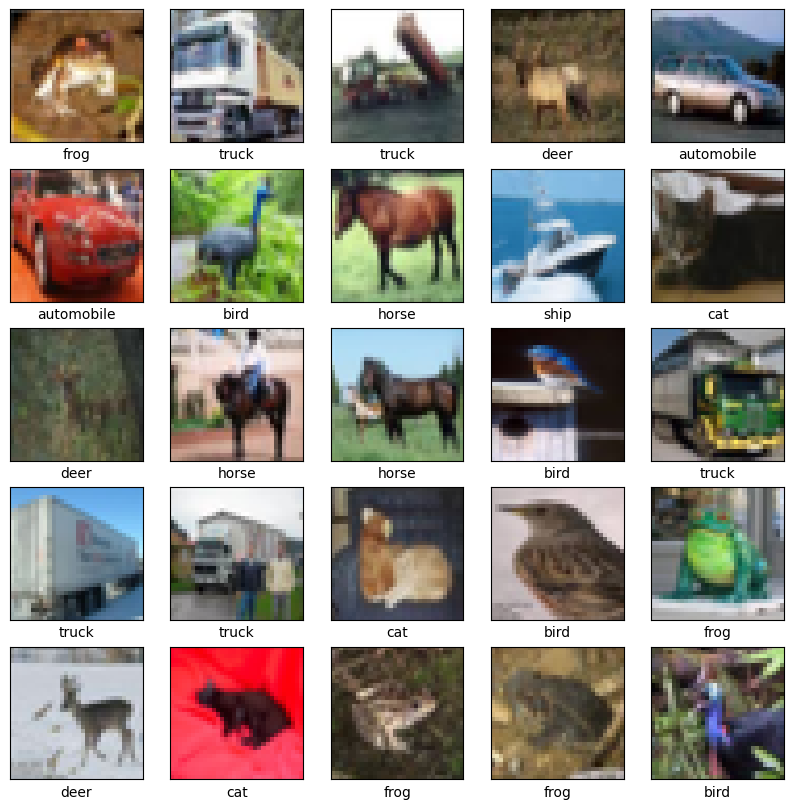

In [5]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Convolutional Neural Network

In [6]:
# Build the conv model.
print("building the convolution model...")
conv_model = keras.Sequential(
    [
        keras.layers.Conv2D(32, (3, 3), input_shape=(32, 32, 3), padding="same"),
        keras.layers.ReLU(name="relu1"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), padding="same"),
        keras.layers.ReLU(name="relu2"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), padding="same"),
        keras.layers.ReLU(name="relu3"),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(10),
    ]
)

# Compile the mode with the necessary loss function and optimizer.
print("compiling the convolution model...")
conv_model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Train the model.
print("conv model training...")
conv_hist = conv_model.fit(train_ds, epochs=20, validation_data=test_ds)

building the convolution model...
compiling the convolution model...
conv model training...
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.3144 - loss: 1.8874 - val_accuracy: 0.5078 - val_loss: 1.3938
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5390 - loss: 1.2986 - val_accuracy: 0.5937 - val_loss: 1.1637
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6069 - loss: 1.1238 - val_accuracy: 0.6411 - val_loss: 1.0398
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6502 - loss: 0.9981 - val_accuracy: 0.6481 - val_loss: 1.0104
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6772 - loss: 0.9219 - val_accuracy: 0.6601 - val_loss: 0.9893
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7020 - loss: 0.8604 - val_accuracy: 0.6804 - val_loss: 0.9305
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7213 - loss: 0.8104 - val_accuracy: 0.6842 - val_loss: 0.9217
Epoch 8/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7382 - loss: 0.7601 - val_accuracy: 0.68

## Involutional Neural Network

In [7]:
# Build the involution model.
print("building the involution model...")

inputs = keras.Input(shape=(32, 32, 3))
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_1"
)(inputs)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_2"
)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_3"
)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation="relu")(x)
outputs = keras.layers.Dense(10)(x)

inv_model = keras.Model(inputs=[inputs], outputs=[outputs], name="inv_model")

# Compile the mode with the necessary loss function and optimizer.
print("compiling the involution model...")
inv_model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# train the model
print("inv model training...")
inv_hist = inv_model.fit(train_ds, epochs=20, validation_data=test_ds)

building the involution model...
compiling the involution model...
inv model training...
Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.1428 - loss: 2.2580 - val_accuracy: 0.2830 - val_loss: 2.0715
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3259 - loss: 1.8765 - val_accuracy: 0.3588 - val_loss: 1.8026
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3665 - loss: 1.7706 - val_accuracy: 0.3823 - val_loss: 1.7314
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3823 - loss: 1.7208 - val_accuracy: 0.3904 - val_loss: 1.7034
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3919 - loss: 1.6883 - val_accuracy: 0.4011 - val_loss: 1.6735
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4051 - loss: 1.6605 - val_accuracy: 0.4078 - val_loss: 1.6522
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4141 - loss: 1.6403 - val_accuracy: 0.4155 - val_loss: 1.6313
Epoch 8/20
19

## Comparisons

In this section, we will be looking at both the models and compare a
few pointers.

### Parameters

One can see that with a similar architecture the parameters in a CNN
is much larger than that of an INN (Involutional Neural Network).

In [8]:
conv_model.summary()

inv_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (ReLU)                    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (ReLU)                    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (ReLU)                    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 957,536 (3.65 MB)

 Trainable params: 319,178 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 638,358 (2.44 MB)

Model: "inv_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inv_1 (Involution)              │ [(None, 32, 32, 3),    │            26 │
│                                 │ (None, 32, 32, 9, 1,   │               │
│                                 │ 1)]                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inv_2 (Involution)              │ [(None, 16, 16, 3),    │            26 │
│                                 │ (None, 16, 16, 9, 1,   │               │
│                                 │ 1)]                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 16, 16, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inv_3 (Involution)              │ [(None, 8, 8, 3),      │            26 │
│                                 │ (None, 8, 8, 9, 1, 1)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 8, 8, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,230 (153.25 KB)

 Trainable params: 13,074 (51.07 KB)

 Non-trainable params: 6 (24.00 B)

 Optimizer params: 26,150 (102.15 KB)

### Loss and Accuracy Plots

Here, the loss and the accuracy plots demonstrate that INNs are slow
learners (with lower parameters).

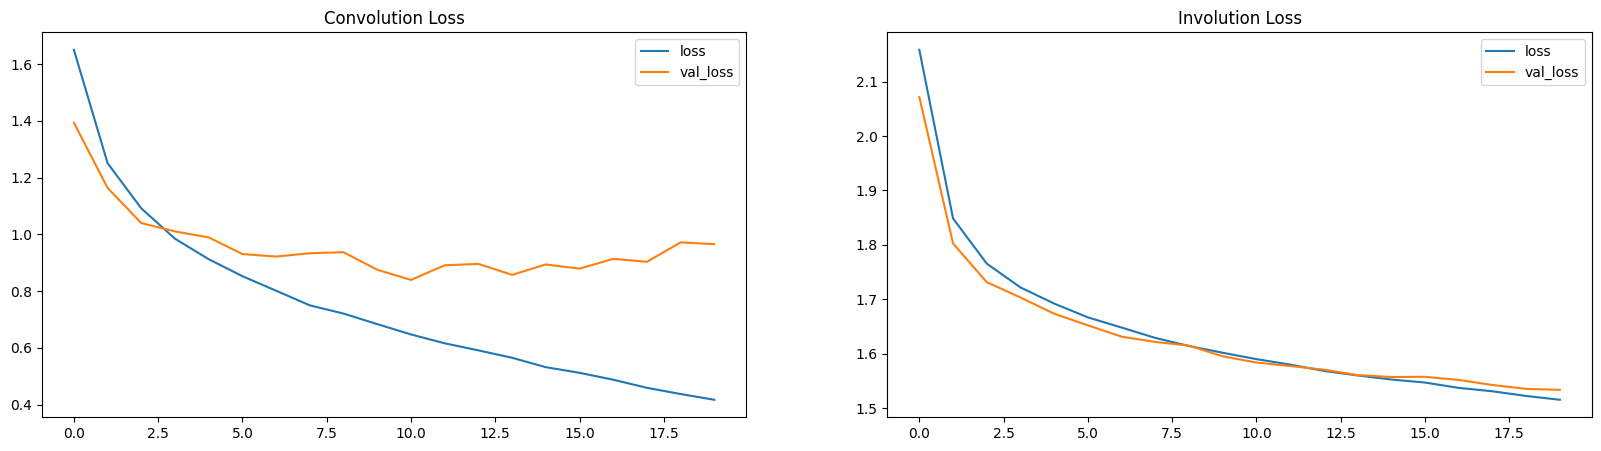

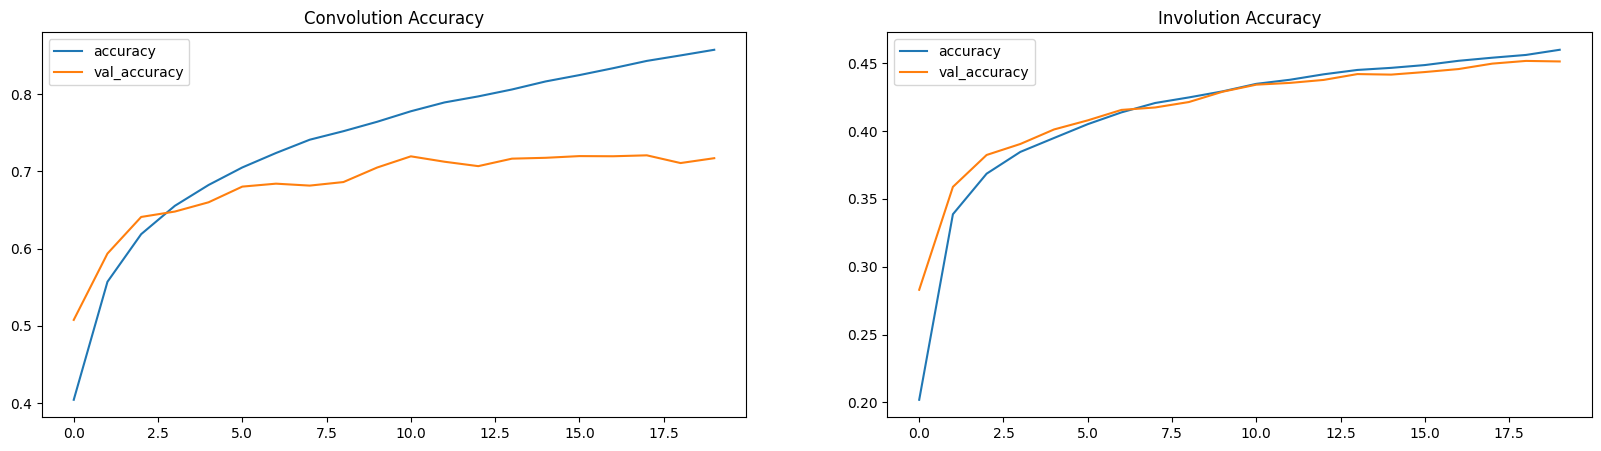

In [9]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title("Convolution Loss")
plt.plot(conv_hist.history["loss"], label="loss")
plt.plot(conv_hist.history["val_loss"], label="val_loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()

plt.show()

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title("Convolution Accuracy")
plt.plot(conv_hist.history["accuracy"], label="accuracy")
plt.plot(conv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()

plt.show()

## Visualizing Involution Kernels

To visualize the kernels, we take the sum of **K×K** values from each
involution kernel. **All the representatives at different spatial
locations frame the corresponding heat map.**

The authors mention:

"Our proposed involution is reminiscent of self-attention and
essentially could become a generalized version of it."

With the visualization of the kernel we can indeed obtain an attention
map of the image. The learned involution kernels provides attention to
individual spatial positions of the input tensor. The
**location-specific** property makes involution a generic space of models
in which self-attention belongs.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


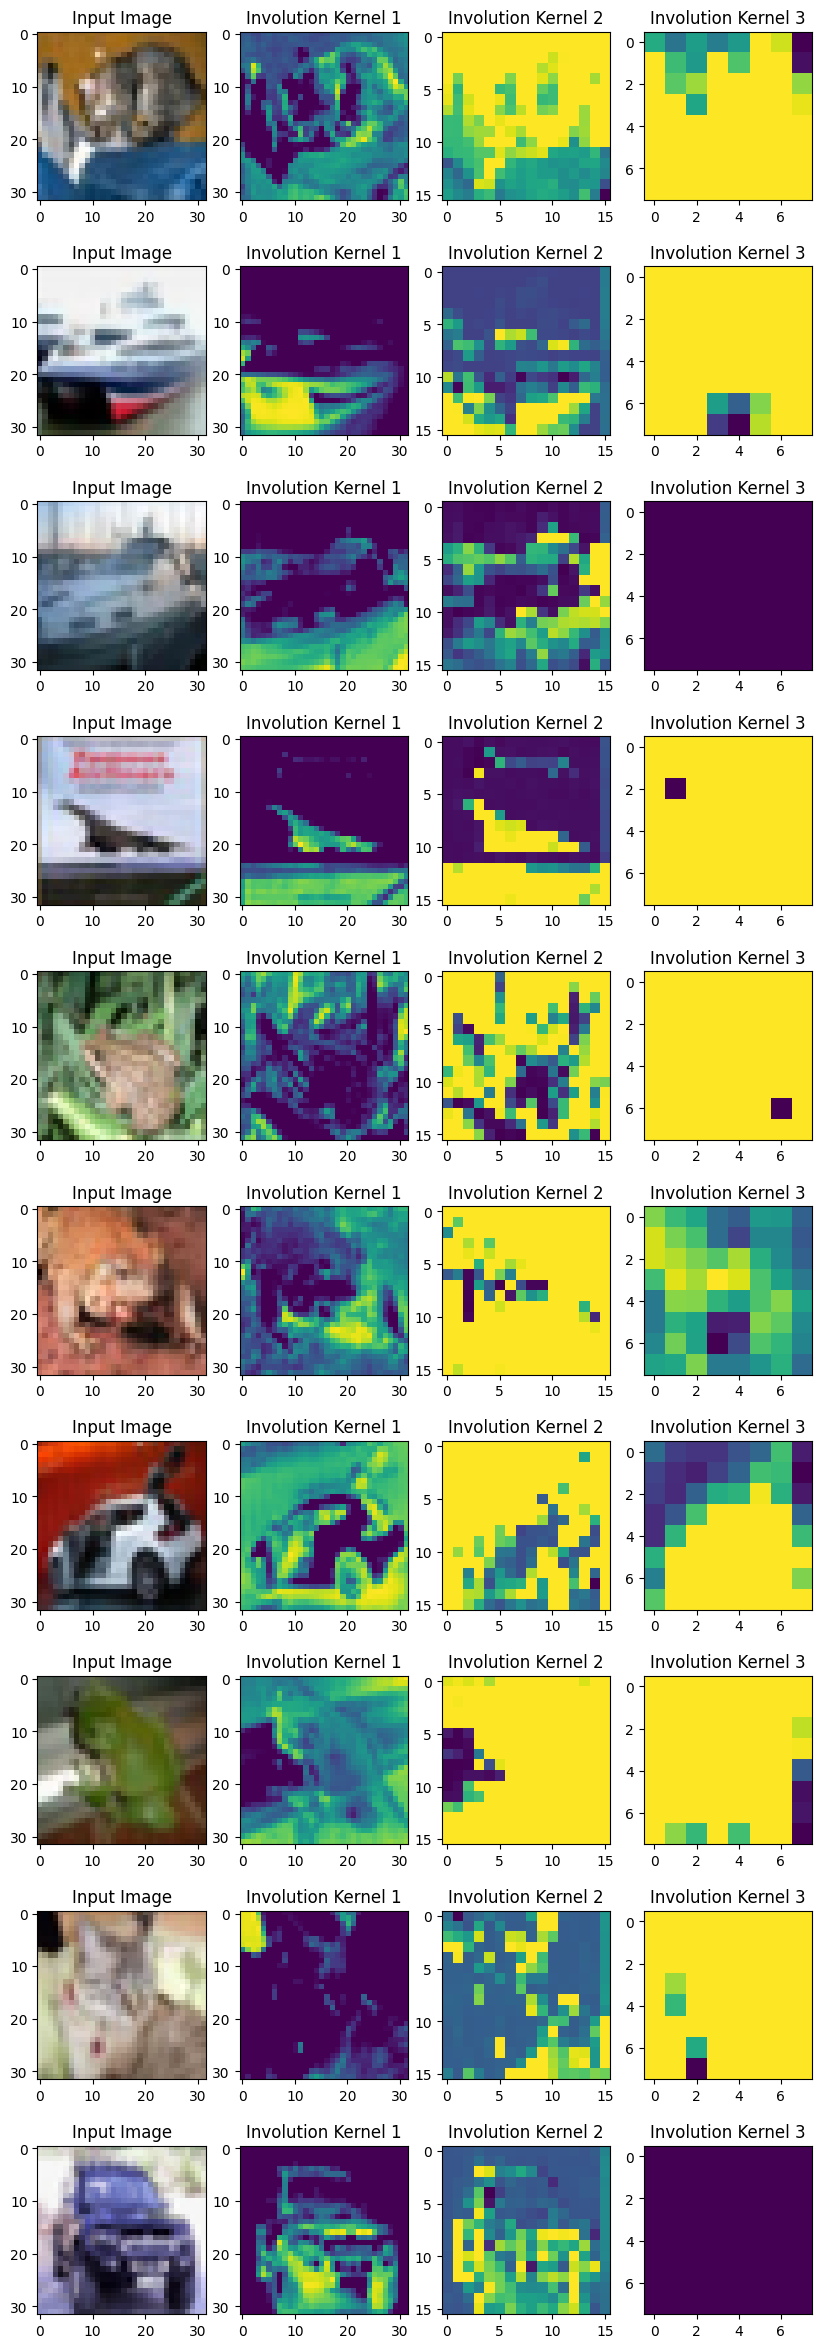

In [10]:
layer_names = ["inv_1", "inv_2", "inv_3"]
outputs = [inv_model.get_layer(name).output[1] for name in layer_names]
vis_model = keras.Model(inv_model.input, outputs)

fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(10, 30))

for ax, test_image in zip(axes, test_images[:10]):
    (inv1_kernel, inv2_kernel, inv3_kernel) = vis_model.predict(test_image[None, ...])
    inv1_kernel = tf.reduce_sum(inv1_kernel, axis=[-1, -2, -3])
    inv2_kernel = tf.reduce_sum(inv2_kernel, axis=[-1, -2, -3])
    inv3_kernel = tf.reduce_sum(inv3_kernel, axis=[-1, -2, -3])

    ax[0].imshow(keras.utils.array_to_img(test_image))
    ax[0].set_title("Input Image")

    ax[1].imshow(keras.utils.array_to_img(inv1_kernel[0, ..., None]))
    ax[1].set_title("Involution Kernel 1")

    ax[2].imshow(keras.utils.array_to_img(inv2_kernel[0, ..., None]))
    ax[2].set_title("Involution Kernel 2")

    ax[3].imshow(keras.utils.array_to_img(inv3_kernel[0, ..., None]))
    ax[3].set_title("Involution Kernel 3")

## Conclusions

In this example, the main focus was to build an `Involution` layer which
can be easily reused. While our comparisons were based on a specific
task, feel free to use the layer for different tasks and report your
results.

According to me, the key take-away of involution is its
relationship with self-attention. The intuition behind location-specific
and channel-spefic processing makes sense in a lot of tasks.

Moving forward one can:

- Look at [Yannick's video](https://youtu.be/pH2jZun8MoY) on
    involution for a better understanding.
- Experiment with the various hyperparameters of the involution layer.
- Build different models with the involution layer.
- Try building a different kernel generation method altogether.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/involution)
and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/involution).